# Imports

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw, rdChemReactions
import pandas as pd
import numpy as np
import re
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, TransformerConv
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn

# Data Parsing

### Load dataset

In [2]:
df = pd.read_csv('./data/dataSetB.csv')
df = df[[col for col in df if "NameRxn" in col]]

### Smiles to Reactions

In [3]:
def parse_rxn_smile(rxn_smile,reactant_set):
    before_rxn_smile, products_smile = rxn_smile.split('>>')

    reactant_indices = [int(x) for x in re.findall(r'\d+', reactant_set)]

    potential_reactants = before_rxn_smile.split('.')
    reactants = [potential_reactants[idx] for idx in reactant_indices]

    products = products_smile.split('.')

    return reactants,products

In [4]:
rxn_list = []
for idx, row in df.iterrows():
    rxn_smile = row['rxnSmiles_Mapping_NameRxn']
    reactant_set = row['reactantSet_NameRxn']

    reactants, products = parse_rxn_smile(rxn_smile,reactant_set)

    reactant_mols = [Chem.MolFromSmiles(reactant) for reactant in reactants]
    product_mols = [Chem.MolFromSmiles(product) for product in products]

    rxn_list.append((reactant_mols,product_mols))


### Reaction cleanup

In [ ]:
# problems_w = 0
# problems_e = 0
# i = 0
cleaned_rxn_list = []
for idx, rxn in enumerate(rxn_list):
    rd_rxn = rdChemReactions.ChemicalReaction()
    for rctnt in rxn[0]:
        rd_rxn.AddReactantTemplate(rctnt)
    for prdct in rxn[1]:
        rd_rxn.AddProductTemplate(prdct)

    warnings, errors = rd_rxn.Validate()
    if(not warnings and not errors and not len(rxn[1])>1):
        cleaned_rxn_list.append(rd_rxn)
    # problems_w+=warnings
    # problems_e+=errors
# print(problems_w,problems_e)

# Feature extraction

In [6]:
symbol_list = [
        'C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br', 'Li', 'Na', 'K',
        'Mg', 'B', 'Sn', 'I', 'Se', 'unk'
    ]

hyb_list = [
    Chem.rdchem.HybridizationType.SP, 
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2
    ]

bt_list = [
    Chem.rdchem.BondType.SINGLE,
    Chem.rdchem.BondType.DOUBLE,
    Chem.rdchem.BondType.TRIPLE,
    Chem.rdchem.BondType.AROMATIC
]

sym_encoder = OneHotEncoder(dtype=np.float32, sparse_output=False)
hyb_encoder = OneHotEncoder(dtype=np.float32, sparse_output=False)
bt_encoder = OneHotEncoder(dtype=np.float32, sparse_output=False)

sym_encoder.fit(np.array(symbol_list).reshape(-1,1))
hyb_encoder.fit(np.array(hyb_list).reshape(-1,1))
bt_encoder.fit(np.array(bt_list).reshape(-1,1))

def one_hot_encode(symbol,encoder):
    try: 
        return torch.tensor(encoder.transform(np.array([[symbol]])).reshape(-1), dtype=torch.float)
    except:
        return torch.tensor(encoder.transform(np.array([['unk']])).reshape(-1), dtype=torch.float)


In [7]:
def get_atom_features(atom):
    sym_one_hot = one_hot_encode(atom.GetSymbol(),sym_encoder)
    formal_charge = torch.tensor([atom.GetFormalCharge()], dtype=torch.float)
    degree = torch.tensor([atom.GetDegree()], dtype=torch.float)
    total_hydrogens = torch.tensor([atom.GetTotalNumHs()], dtype=torch.float)
    valence = torch.tensor([atom.GetTotalValence()], dtype=torch.float)
    is_aromatic = torch.tensor([atom.GetIsAromatic()], dtype=torch.float)
    is_in_ring = torch.tensor([atom.IsInRing()], dtype=torch.float)
    hyb_one_hot = one_hot_encode(atom.GetHybridization(),hyb_encoder)
    
    features = torch.cat([sym_one_hot, formal_charge, degree, total_hydrogens, valence, is_aromatic, is_in_ring, hyb_one_hot])

    return features


def get_bond_features(bond):
    # bond type, conjugation, ring membership,  stereo config
    bt_one_hot = one_hot_encode(bond.GetBondType(),bt_encoder)
    is_conjugated = torch.tensor([bond.GetIsConjugated()],dtype=torch.float)
    is_in_ring = torch.tensor([bond.IsInRing()],dtype=torch.float)

    
    features = torch.cat([bt_one_hot,is_conjugated,is_in_ring])

    return(features)


# Input Preparation

In [8]:
def get_bonds_to_break(reactants,product):
    reactant_bonds = set()
    product_bonds = set()
    for rc in reactants:
        for bond in rc.GetBonds():
            atom1_map = bond.GetBeginAtom().GetAtomMapNum()
            atom2_map = bond.GetEndAtom().GetAtomMapNum()

            if atom1_map and atom2_map:
                reactant_bonds.add(tuple(sorted((atom1_map, atom2_map))))

    for bond in product.GetBonds():
        atom1_map = bond.GetBeginAtom().GetAtomMapNum()
        atom2_map = bond.GetEndAtom().GetAtomMapNum()
        
        if atom1_map and atom2_map:
            product_bonds.add(tuple(sorted((atom1_map, atom2_map))))

    created_bonds = reactant_bonds - product_bonds
    bonds_to_break = product_bonds - reactant_bonds

    return bonds_to_break

# Model Definition

In [20]:
from torch_geometric.nn import global_mean_pool
class GraphTransformer(nn.Module):
    def __init__(self, in_channels, edge_dim, hidden_channels, out_channels, heads=8):
        super().__init__()
        assert hidden_channels % heads == 0, "Hidden channels must be divisible by heads"
        out_channels_per_head = hidden_channels // heads
        
        self.conv1 = TransformerConv(in_channels, out_channels_per_head, heads=heads, edge_dim=edge_dim)
        self.conv2 = TransformerConv(hidden_channels, out_channels, heads=1, concat=False, edge_dim=edge_dim)

    def forward(self, x, edge_index, edge_attr):
        h = self.conv1(x, edge_index, edge_attr=edge_attr)
        h = F.leaky_relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.conv2(h, edge_index, edge_attr=edge_attr)
        return h

class LinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=1):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, h_src, h_dst, edge_attr, h_graph):
        # Concatenate source, destination, edge, and graph features
        combined_embeds = torch.cat([h_src, h_dst, edge_attr, h_graph], dim=1)
        return self.mlp(combined_embeds)


class GNN_LinkPredictor(nn.Module):
    def __init__(self, node_in, edge_in, gnn_hidden, mlp_hidden):
        super().__init__()
        self.gnn = GraphTransformer(
            in_channels=node_in,
            edge_dim=edge_in,
            hidden_channels=gnn_hidden,
            out_channels=gnn_hidden
        )
        # Calculate predictor input size: 2*node_hidden + edge_features + graph_hidden
        predictor_in_channels = (gnn_hidden * 2) + edge_in + gnn_hidden
        self.predictor = LinkPredictor(predictor_in_channels, mlp_hidden)

    # predicts a score for every edge.
    def forward(self, x, edge_index, edge_attr, batch):
        node_embeddings = self.gnn(x, edge_index, edge_attr)
        graph_embedding = global_mean_pool(node_embeddings, batch)
        
        # features
        source_embeds = node_embeddings[edge_index[0]]
        target_embeds = node_embeddings[edge_index[1]]
        
        # graph embedding to match the number of edges
        graph_embedding_expanded = graph_embedding[batch[edge_index[0]]]

        return self.predictor(source_embeds, target_embeds, edge_attr, graph_embedding_expanded)

In [10]:
def rxn_to_graph(rxn):
    reactants = rxn.GetReactants()
    # single product
    product = rxn.GetProducts()[0]
    
    atom_features_list = [get_atom_features(atom) for atom in product.GetAtoms()]
    x = torch.stack(atom_features_list, dim=0)

    source_nodes, target_nodes = [], []
    bond_features_list = []

    for bond in product.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        bond_feat = get_bond_features(bond)
        
        # both directions for GNN message passing
        source_nodes.extend([start, end])
        target_nodes.extend([end, start])
        
        # bond features for both directions
        bond_features_list.extend([bond_feat, bond_feat])

    edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)
    edge_attr = torch.stack(bond_features_list, dim=0)

    bonds_to_break_maps = get_bonds_to_break(reactants, product)
    
    # lookup map from atom map number to its index
    map_to_idx = {atom.GetAtomMapNum(): atom.GetIdx() for atom in product.GetAtoms()}

    bonds_to_break_indices = set()
    for map1, map2 in bonds_to_break_maps:
        if map1 in map_to_idx and map2 in map_to_idx:
            idx1, idx2 = map_to_idx[map1], map_to_idx[map2]
            bonds_to_break_indices.add(tuple(sorted((idx1, idx2))))
            
    # label (0 or 1) every bond in the product graph
    edge_labels = []
    # unique bonds (every other edge in edge_index)
    for i in range(0, len(source_nodes), 2):
        start_node, end_node = source_nodes[i], target_nodes[i]
        bond_tuple = tuple(sorted((start_node, end_node)))
        
        if bond_tuple in bonds_to_break_indices:
            edge_labels.append(1)  # Label 1 bonds to break (positive class)
        else:
            edge_labels.append(0)  # Label 0 bonds that are NOT broken (negative class)
            
    # label for each directed edge
    # duplicate the list: [0, 1, 0] becomes [0, 1, 0, 0, 1, 0]
    edge_labels.extend(edge_labels)
    # ground truth
    y = torch.tensor(edge_labels, dtype=torch.float).view(-1, 1)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    
    

In [11]:
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}.")

dataset = [rxn_to_graph(rxn) for rxn in tqdm(cleaned_rxn_list)]
# dataset = torch.load('rxn_graphs.pt')

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset[:train_size]
val_dataset = dataset[train_size : train_size + val_size]
test_dataset = dataset[train_size + val_size :]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Using cuda.


100%|██████████| 48232/48232 [25:22<00:00, 31.67it/s]


In [12]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
torch.save(dataset, f'rxn_graphs-{timestr}.pt')

In [21]:
from sklearn.metrics import roc_auc_score
from torch_geometric.utils import negative_sampling

num_negatives = 0
num_positives = 0
for data in train_dataset:
    num_positives += data.y.sum()
    num_negatives += len(data.y) - data.y.sum()

pos_weight = num_negatives / num_positives
print(f"Number of negative samples: {num_negatives}")
print(f"Number of positive samples: {num_positives}")
print(f"Positive Class Weight: {pos_weight:.2f}")
pos_weight_tensor = torch.tensor([pos_weight], device=device)


# Model instantiation
node_feature_dim = dataset[0].num_node_features
edge_feature_dim = dataset[0].num_edge_features


model = GNN_LinkPredictor(node_feature_dim, edge_feature_dim, gnn_hidden=128, mlp_hidden=32).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)


def train(loader):
    model.train()
    for batch in tqdm(loader, desc="Training"):
        batch = batch.to(device)
        optimizer.zero_grad()
        
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        
        # The ground truth
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()

@torch.no_grad()
def test(loader):
    model.eval()
    all_preds, all_labels = [], []
    for batch in loader:
        batch = batch.to(device)
        
        preds = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
        
        all_preds.append(preds.sigmoid().cpu())
        all_labels.append(batch.y.cpu())
    
    if not all_labels or len(all_labels[0]) == 0:
        return 0.0, None, None
    
    predictions_tensor = torch.cat(all_preds)
    labels_tensor = torch.cat(all_labels)

    auc_score = roc_auc_score(labels_tensor, predictions_tensor)
    return auc_score, labels_tensor, predictions_tensor




Number of negative samples: 2109482.0
Number of positive samples: 58134.0
Positive Class Weight: 36.29


In [22]:
for epoch in range(1, 21):
   train(train_loader)
   val_auc,_, _ = test(val_loader)
   print(f'Epoch: {epoch:02d}, Val AUC: {val_auc:.4f}')

Training: 100%|██████████| 1206/1206 [00:12<00:00, 94.71it/s] 


Epoch: 01, Val AUC: 0.5809


Training: 100%|██████████| 1206/1206 [00:11<00:00, 100.54it/s]


Epoch: 02, Val AUC: 0.5931


Training: 100%|██████████| 1206/1206 [00:12<00:00, 99.23it/s] 


Epoch: 03, Val AUC: 0.6002


Training: 100%|██████████| 1206/1206 [00:12<00:00, 99.10it/s]


Epoch: 04, Val AUC: 0.6064


Training: 100%|██████████| 1206/1206 [00:12<00:00, 97.48it/s]


Epoch: 05, Val AUC: 0.6109


Training: 100%|██████████| 1206/1206 [00:11<00:00, 102.85it/s]


Epoch: 06, Val AUC: 0.6170


Training: 100%|██████████| 1206/1206 [00:12<00:00, 99.38it/s] 


Epoch: 07, Val AUC: 0.6215


Training: 100%|██████████| 1206/1206 [00:12<00:00, 96.56it/s] 


Epoch: 08, Val AUC: 0.6253


Training: 100%|██████████| 1206/1206 [00:10<00:00, 111.94it/s]


Epoch: 09, Val AUC: 0.6295


Training: 100%|██████████| 1206/1206 [00:12<00:00, 100.26it/s]


Epoch: 10, Val AUC: 0.6335


Training: 100%|██████████| 1206/1206 [00:11<00:00, 102.83it/s]


Epoch: 11, Val AUC: 0.6371


Training: 100%|██████████| 1206/1206 [00:11<00:00, 104.92it/s]


Epoch: 12, Val AUC: 0.6408


Training: 100%|██████████| 1206/1206 [00:11<00:00, 102.02it/s]


Epoch: 13, Val AUC: 0.6431


Training: 100%|██████████| 1206/1206 [00:12<00:00, 98.90it/s]


Epoch: 14, Val AUC: 0.6462


Training: 100%|██████████| 1206/1206 [00:12<00:00, 99.65it/s]


Epoch: 15, Val AUC: 0.6484


Training: 100%|██████████| 1206/1206 [00:11<00:00, 102.93it/s]


Epoch: 16, Val AUC: 0.6504


Training: 100%|██████████| 1206/1206 [00:11<00:00, 101.44it/s]


Epoch: 17, Val AUC: 0.6528


Training: 100%|██████████| 1206/1206 [00:12<00:00, 99.80it/s]


Epoch: 18, Val AUC: 0.6543


Training: 100%|██████████| 1206/1206 [00:12<00:00, 97.84it/s]


Epoch: 19, Val AUC: 0.6560


Training: 100%|██████████| 1206/1206 [00:12<00:00, 100.25it/s]


Epoch: 20, Val AUC: 0.6580


Evaluating final model and generating ROC curve...
              precision    recall  f1-score   support

         0.0       0.99      0.55      0.71    262152
         1.0       0.05      0.82      0.09      7210

    accuracy                           0.56    269362
   macro avg       0.52      0.69      0.40    269362
weighted avg       0.97      0.56      0.69    269362



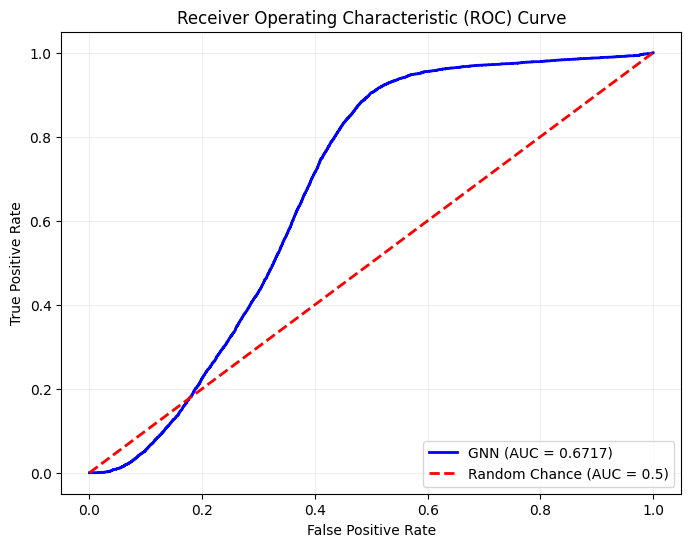

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, classification_report

# --- After your training loop is finished ---
print("Evaluating final model and generating ROC curve...")

# 1. Get the final AUC, labels, and predictions from your test set
final_auc, true_labels, predictions = test(test_loader) # or use val_loader

binary_preds = (predictions > 0.5).int()

print(classification_report(true_labels,binary_preds))

if true_labels is not None:
    # 2. Calculate the points for the ROC curve
    fpr, tpr, _ = roc_curve(true_labels, predictions)

    # 3. Plot the curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'GNN (AUC = {final_auc:.4f})')
    
    # Plot the random chance line
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Chance (AUC = 0.5)')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.2)
    plt.show()